In [29]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, add
from tensorflow.keras.layers import BatchNormalization, Conv3D, ConvLSTM2D, MaxPooling3D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, utils
from tensorflow.keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import sys 
from imageLoader import *
from random import shuffle
import shutil

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5775142656379023569
xla_global_id: -1
]


In [13]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [14]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU'))

0

In [15]:
in_dir = "D:\Bixbyte\LSTM_HockeyFight\data"
default_path = 'D:/Bixbyte/LSTM_HockeyFight'
method = 'ConvLSTM'
model_path = default_path + '/model/model_hockey_' + method + '.h5'

train_path = default_path + '/train/'
normal_path_train = train_path + 'normal/'
crime_path_train = train_path + 'crime/'

test_path = default_path + '/test/'
normal_path_test = test_path + 'normal/'
crime_path_test = test_path + 'crime/'

val_path = default_path + '/val/'
normal_path_val = val_path + 'normal/'
crime_path_val = val_path + 'crime/'

if not (os.path.exists(train_path)):
    os.mkdir(train_path)
    os.mkdir(normal_path_train)
    os.mkdir(crime_path_train)
    
if not (os.path.exists(test_path)):
    os.mkdir(test_path)
    os.mkdir(normal_path_test)
    os.mkdir(crime_path_test)
    
if not (os.path.exists(val_path)):
    os.mkdir(val_path)
    os.mkdir(normal_path_val)
    os.mkdir(crime_path_val)

images_per_file = 20
img_size = 224

In [16]:
def get_frames(current_dir, file_name):
    in_file = os.path.join(current_dir, file_name)    
    images = []    
    vidcap = cv2.VideoCapture(in_file)    
    success,image = vidcap.read()       
    count = 0

    while count < images_per_file:
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = cv2.resize(RGB_img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        images.append(res)
        success,image = vidcap.read()
        count += 1
        
    result = np.array(images)    
    result = (result / 255.).astype(np.float16)     
    return result

In [17]:
def label_video_names(in_dir):   
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
       
    for current_dir, dir_names, file_names in os.walk(in_dir):      
        for file_name in file_names:     
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                                 
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)   
    names, labels = zip(*c)           
    return names, labels

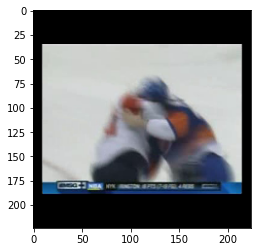

In [51]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)
names[12]
frames = get_frames(in_dir, names[12])
visible_frame = (frames*255).astype('uint8')
plt.imshow(visible_frame[3])

In [18]:
def process_dataset(list_videos, labels, value):
    count = 0
    for i in range(len(list_videos)):
        item = list_videos[i]
        cap = cv2.VideoCapture(os.path.join(in_dir, item))
        frame_count = 0
        pile = []
        while (cap.isOpened()):
            ret, frame_RGB = cap.read()
            if ret == True:
                frame = cv2.cvtColor(frame_RGB, cv2.COLOR_BGR2GRAY)
                resized = cv2.resize(frame, (img_size, img_size), interpolation=cv2.INTER_AREA)
                pile.append(np.asarray(resized))
                frame_count += 1
            else:
                break
                
        indices = np.linspace(0, frame_count-1, images_per_file)
        indices = np.round(indices)
        indices = indices.astype(int)
        
        # Value 0 stands for training data; Value 1 stands for test data
        # Labels [1,0] indicate that there is a crime otherwise there is no-crime
        
        if (labels[i] == [0,1]):
            if (value == 0):
                path = normal_path_train
            elif(value == 1):
                path = normal_path_test
            else:
                path = normal_path_val
        else:
            if (value == 0):
                path = crime_path_train
            elif(value == 1):
                path = crime_path_test
            else:
                path = crime_path_val
            
        count += 1
        for j in range(images_per_file):
            filename = "/input_%d_%d.jpg" % (count, j+1)
            cv2.imwrite(path + filename, pile[indices[j]])

In [19]:
names, labels = label_video_names(in_dir)

In [20]:
split = int(len(names)*0.8)
split_for_val = split + int((len(names) - split) / 2)
process_dataset(names[:split], labels[:split], 0)  # Training Data
process_dataset(names[split:split_for_val], labels[split:split_for_val], 1)  # Test Data
process_dataset(names[split_for_val:], labels[split_for_val:], 2)

In [21]:
def load_model():
    model=Sequential()
    # N 227 227
    model.add(Conv3D(filters=16, kernel_size=(1,11,11), strides=(1,2,2), padding='valid', activation='tanh',
                   input_shape=(images_per_file, img_size, img_size, 1)))
    # N 16 109 109
    model.add(Conv3D(filters=16, kernel_size=(1,5,5), strides=(1,2,2), padding='valid', activation='tanh'))
    # N 16 53 53
    model.add(Conv3D(filters=32, kernel_size=(1,3,3), strides=(1,1,1), padding='valid', activation='tanh'))
    model.add(Conv3D(filters=32, kernel_size=(1,3,3), strides=(1,1,1), padding='valid', activation='tanh'))
    model.add(MaxPooling3D(pool_size=(1,2,2)))
    # N 32 24 24
    model.add(Conv3D(filters=64, kernel_size=(1,3,3), strides=(1,1,1), padding='same', activation='tanh'))
    model.add(Conv3D(filters=64, kernel_size=(1,3,3), strides=(1,1,1), padding='same', activation='tanh'))
    model.add(MaxPooling3D(pool_size=(1,2,2)))
    # N 64 12 12
    model.add(Conv3D(filters=128, kernel_size=(1,3,3), strides=(1,1,1), padding='same', activation='tanh'))
    model.add(Conv3D(filters=128, kernel_size=(1,3,3), strides=(1,1,1), padding='same', activation='tanh'))
    model.add(MaxPooling3D(pool_size=(1,2,2)))
    # N 128 6 6
    model.add(Conv3D(filters=128, kernel_size=(1,3,3), strides=(1,1,1), padding='same', activation='tanh'))
    model.add(Conv3D(filters=32, kernel_size=(1,3,3), strides=(1,1,1), padding='same', activation='tanh'))
    model.add(MaxPooling3D(pool_size=(1,2,2)))
    # N 32 3 3
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

In [22]:
model = load_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 107, 107, 16)  1952      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 52, 52, 16)    6416      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 20, 48, 48, 32)    9248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 24, 24, 32)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 20, 24, 24, 64)    18496     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 20, 24, 24, 64)    3

In [30]:
batch_size_train = int(160 / images_per_file)
datagen = ImageDataGenerator(rescale=1./255)

NameError: name 'K' is not defined

In [ ]:
train_data = datagen.flow_from_directory(train_path,
                                        target_size = (img_size, img_size),
                                        batch_size = batch_size_train,
                                        frames_per_step = images_per_file,
                                        color_mode = 'grayscale',
                                        shuffle = True,
                                        class_mode = 'categorical'
                                        )
test_data = datagen.flow_from_directory(test_path,
                                       target_size = (img_size, img_size),
                                       batch_size = batch_size_train,
                                       frames_per_step = images_per_file,
                                       color_mode = 'grayscale',
                                       shuffle = True,
                                       class_mode = 'categorical'
                                       )

val_data = datagen.flow_from_directory(val_path,
                                       target_size = (img_size, img_size),
                                       batch_size = batch_size_train,
                                       frames_per_step = images_per_file,
                                       color_mode = 'grayscale',
                                       shuffle = True,
                                       class_mode = 'categorical'
                                       )

In [54]:
try:
  model.load_weights(model_path)
except:
  print('No model found.')

callbacks = [EarlyStopping(monitor = 'val_accuracy', patience = 10),
             ModelCheckpoint(filepath = model_path, monitor = 'val_accuracy', save_best_only = True)]
model.fit(train_data,
          batch_size = batch_size_train,
          steps_per_epoch = len(train_data.filenames)/batch_size_train/images_per_file,
          epochs = 100,
          validation_data = val_data,
          validation_steps = len(val_data.filenames)/batch_size_train/images_per_file,
          callbacks = callbacks,
          verbose = 1
          )

No model found.
Epoch 1/100
  5/100 [>.............................] - ETA: 8:41 - loss: 1.8664 - accuracy: 0.5750

KeyboardInterrupt: 

In [50]:
names, labels = label_video_names(in_dir)
train_index = int(len(names) * 0.8)
first_frame_train = get_frames(in_dir, names[1])
first_frame_val = get_frames(in_dir, names[train_index + 1])
val_index = len(names) - train_index
training_set = first_frame_train
val_set = first_frame_val

for i in range(train_index):
    frames = get_frames(in_dir, names[i])
    np.append(training_set, frames)

np.save("train_set", training_set)
shutil.move("train_set.npy", train_path)
    
for j in range(val_index):
    frames_val = get_frames(in_dir, names[j])
    np.append(val_set, frames_val)

np.save("val_set", val_set)
shutil.move("val_set.npy", val_path)

'D:/Bixbyte/LSTM_HockeyFight/val/val_set.npy'